In [1]:
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns 

# Import Encoding for data preprocessing
from sklearn.preprocessing import LabelEncoder

# Import Models
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

# Import Metrics/Tuning 
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV, train_test_split

# Set default plotting parameters
plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams.update({'font.size': 16})

# Context: 
***
- This year in September 2020 onion prices rocketed to a new level. The knee jerk reaction of government is to ban the exports and raid onion traders.
- In reaction to these onion price increases, the government implemented a ban on onion exports on 9/14
- **Objective:** use onion price data to create a model that predicts onion price either for an unseen date between Jan 2020 an Aug 2020 or for an arbitrary date in Sep 2020 

# 1) Data Cleaning:
***
- arrival_date format: dd/mm/YYYY
- export ban after 9/14/2020, but data goes to 9/16/2020



In [2]:
df = pd.read_csv('Data/Onion Prices 2020.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107295 entries, 0 to 107294
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   state         107295 non-null  object 
 1   district      107295 non-null  object 
 2   market        107295 non-null  object 
 3   commodity     107295 non-null  object 
 4   variety       107295 non-null  object 
 5   arrival_date  107295 non-null  object 
 6   min_price     107295 non-null  int64  
 7   max_price     107295 non-null  int64  
 8   modal_price   107295 non-null  float64
dtypes: float64(1), int64(2), object(6)
memory usage: 7.4+ MB


### Check for null values
There does not appear to be any null values requiring imputation

### How many distinct buckets are there?

In [3]:
print("Number of Districts: {}".format(len(df['district'].unique())))
print("Number of States: {}".format(len(df['state'].unique())))
print("Number of Markets: {}".format(len(df['market'].unique())))
print("Number of Onion Varieties: {}".format(len(df['variety'].unique())))
print("Number of Commodities: {}".format(len(df['commodity'].unique())))

Number of Districts: 315
Number of States: 22
Number of Markets: 905
Number of Onion Varieties: 21
Number of Commodities: 1


In [41]:
print('Min Modal Price: {}'.format( df.modal_price.min()))
print('Mean Modal Price: {}'.format( df.modal_price.mean()))
print('Mean MAx Price: {}'.format( df.modal_price.max()))


Min Modal Price: 20.0
Mean Modal Price: 2109.523217298103
Mean MAx Price: 22000.0


#### Verified that there are no null or negative price values that will require imputation
***

### Drop Commodity field because there is only 1 commodity type (onion)
If all datapoints share the same value for this field, it will not create meaningful separation

In [5]:
df.drop('commodity', axis=1, inplace=True)

### Convert arrival_date into a datetime object and set as index


In [6]:
df['arrival_date'] = pd.to_datetime(df['arrival_date'], dayfirst=True)
df.index = df.arrival_date
df.drop('arrival_date', axis=1, inplace=True);
df.head()

,state,district,market,variety,min_price,max_price,modal_price
arrival_date,,,,,,,
2020-01-03,Andhra Pradesh,Kurnool,Kurnool,Local,1350,4390,3100.0
2020-01-04,Andhra Pradesh,Kurnool,Kurnool,Local,1390,4400,3200.0
2020-01-06,Andhra Pradesh,Kurnool,Kurnool,Local,1460,5150,4310.0
2020-01-07,Andhra Pradesh,Kurnool,Kurnool,Local,2010,5200,4200.0
2020-01-10,Andhra Pradesh,Kurnool,Kurnool,Local,1320,4050,3300.0


### Convert Categorical Variables to Ordinal Encoding
- Note: These values are nominal in nature, so dummy variables should be preferred to avoid introducing a "ranking" effect in the mapping. Since there are thousands of potential variables to one-hot encode, I have opted for ordinal encoding to avoid dimensionality explosion. Further analysis will likely be required. <br>
- Explore Target Encoding

In [7]:
state_mapper = {val:idx for idx, val in enumerate(df['state'].unique())}
district_mapper = {val:idx for idx, val in enumerate(df['district'].unique())}
market_mapper = {val:idx for idx, val in enumerate(df['market'].unique())}
variety_mapper = {val:idx for idx, val in enumerate(df['variety'].unique())}

encode_mapping = {'state': state_mapper, 
                  'district': district_mapper,
                  'market': market_mapper,
                  'variety': variety_mapper}

df.replace(encode_mapping, inplace=True) 
df.fillna(0, inplace=True)
df.head()

,state,district,market,variety,min_price,max_price,modal_price
arrival_date,,,,,,,
2020-01-03,0,0,0,0,1350,4390,3100.0
2020-01-04,0,0,0,0,1390,4400,3200.0
2020-01-06,0,0,0,0,1460,5150,4310.0
2020-01-07,0,0,0,0,2010,5200,4200.0
2020-01-10,0,0,0,0,1320,4050,3300.0


### Add Features for Month, Week, Day
- This will help us build plots to understand modal price distributions/trends over time

In [8]:
# Add Time features
df['month'] = pd.DatetimeIndex(df.index).month
df['week'] = pd.DatetimeIndex(df.index).isocalendar().week.astype('int')
df['day'] = pd.DatetimeIndex(df.index).isocalendar().day.astype('int')
df.head()

,state,district,market,variety,min_price,max_price,modal_price,month,week,day
arrival_date,,,,,,,,,,
2020-01-03,0,0,0,0,1350,4390,3100.0,1,1,5
2020-01-04,0,0,0,0,1390,4400,3200.0,1,1,6
2020-01-06,0,0,0,0,1460,5150,4310.0,1,2,1
2020-01-07,0,0,0,0,2010,5200,4200.0,1,2,2
2020-01-10,0,0,0,0,1320,4050,3300.0,1,2,5


# 2) Data Exploration
***

### Plot average Modal Price
Modal Onion Price appears to be highest in early 2020 and steadily declined through mid year. Over last 30 days of data, onion prices have increased quickly

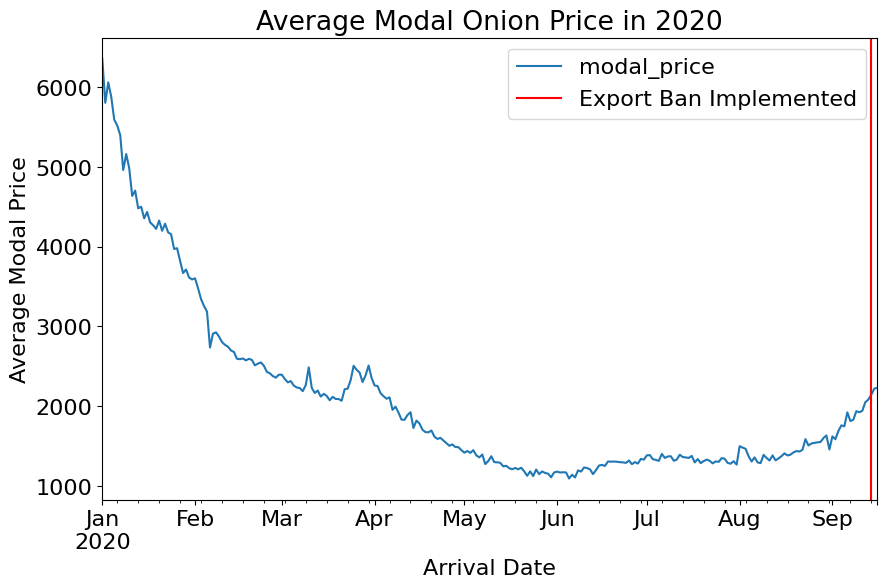

In [9]:
modal_price = df[['modal_price']].groupby(df.index)[['modal_price']].mean()
modal_price.sort_index(ascending=True, inplace=True)
modal_price.plot();
plt.axvline(dt.datetime(2020, 9, 14), label='Export Ban Implemented', color='r')
plt.legend()
plt.xlabel('Arrival Date');
plt.ylabel('Average Modal Price');
plt.title('Average Modal Onion Price in 2020');
plt.show();

### Plot Modal Price Volatility
- Onion price volatility has peaked in August and September 2020

<Figure size 1000x600 with 0 Axes>

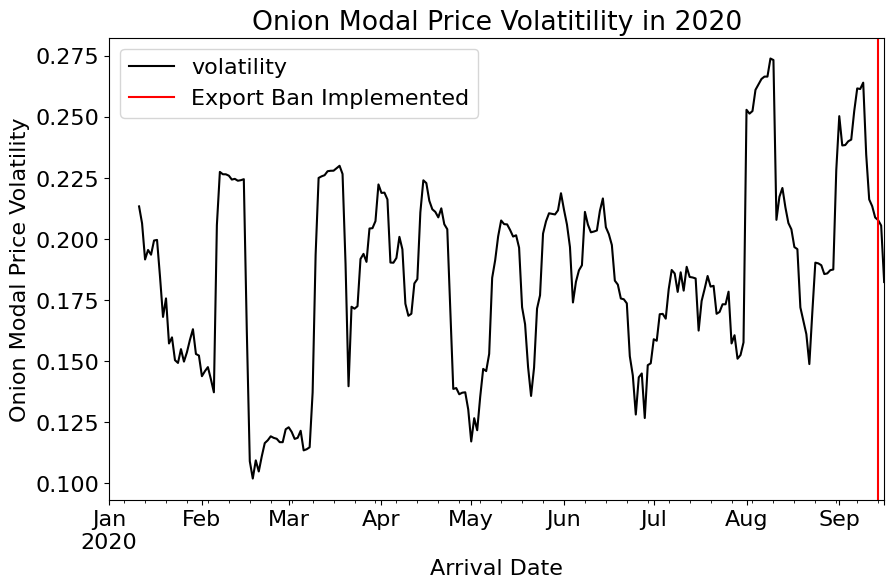

In [11]:
plt.clf()
window = 10

plt.figure()
modal_price['volatility'] = modal_price.pct_change().rolling(window).std()**0.5
modal_price['volatility'].plot(color='k');
plt.axvline(dt.datetime(2020, 9, 14), label='Export Ban Implemented', color='r')
plt.legend()
plt.xlabel('Arrival Date');
plt.ylabel('Onion Modal Price Volatility') ;
plt.title('Onion Modal Price Volatitility in 2020');
plt.show()

### Plot Modal Price Distribution
- Modal Price distribution is right-skewed with a mean value of ~2100
- No negative values requiring imputation

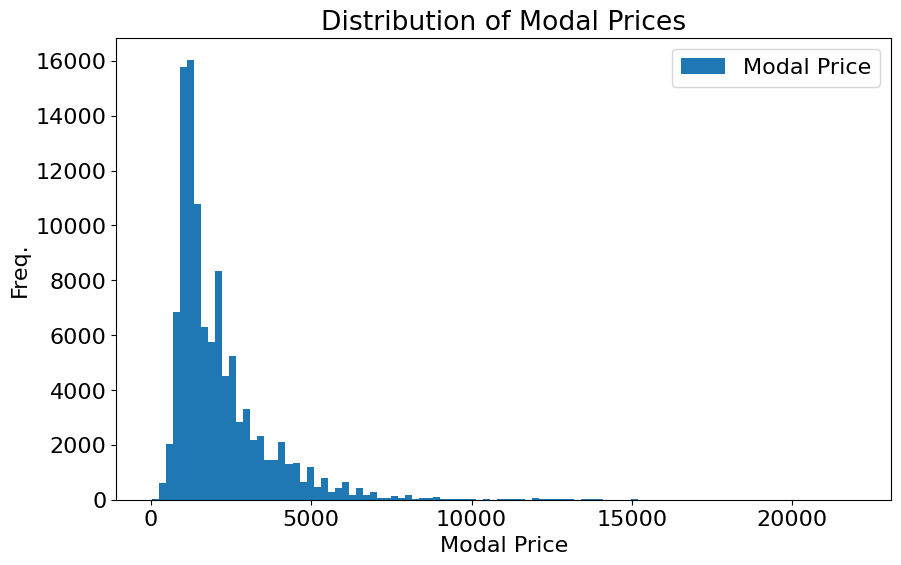

In [10]:
# df['modal_price'].hist()
# sns.histplot(data=df, x='modal_price')

plt.hist(df['modal_price'], bins=100, label='Modal Price')

plt.xlabel('Modal Price')
plt.ylabel('Freq.')
plt.title('Distribution of Modal Prices')
plt.legend()
plt.show()

### Modal Price Ranges by state
**Takeaway:** There is definitely a degree of variability in modal price across states. Creating predictions/features grouped by state/region will be an important area to explore. <br>
**Highest Price States:** Kerala (9) & Odisha (14) <br>
**Lowest Price States:** Jammu and Kashmir (6) & Telangana (17)

In [43]:
# Un-comment below to see state mappings
# state_mapper

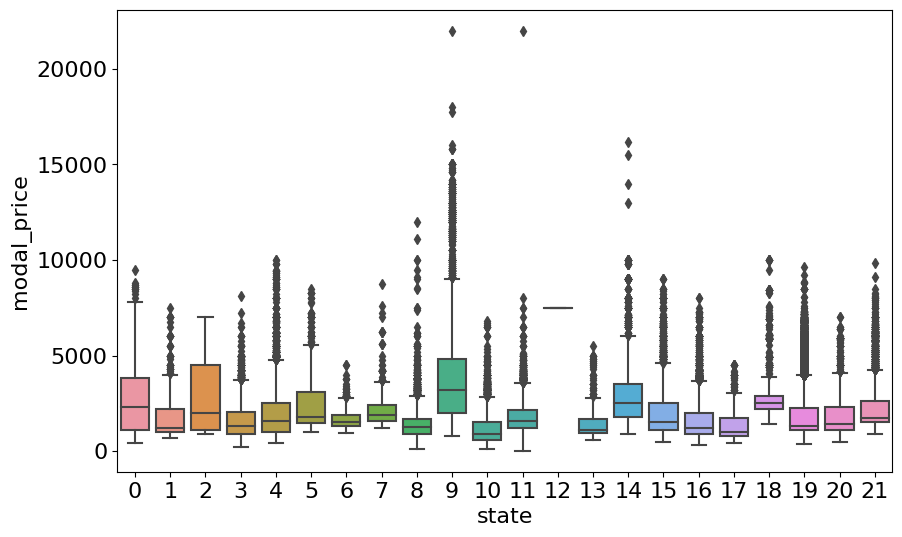

In [13]:
sns.boxplot(x='state',y='modal_price',data=df)
plt.show()

### Modal Price Ranges by Onion Variety
**Takeaway:** There are groupings of similarly priced onion, but certain varieties are outliers. <br>
**Highest Price Varieties:** Bellary(20) & Small(15) <br>
**Lowest Price Varieties:** Telagi(12) & Bangalore-Samall(8)

In [14]:
# Un-comment below to see variety mappings
# variety_mapper

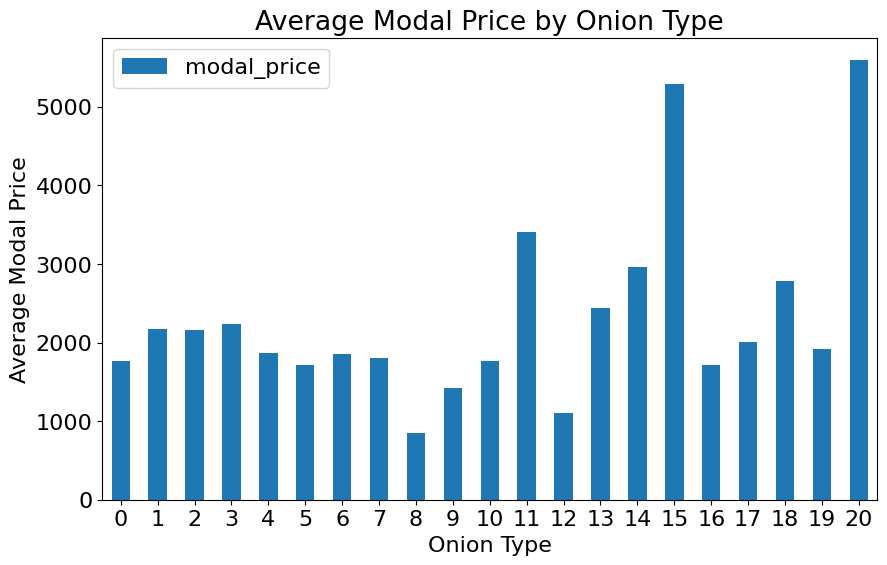

In [15]:
onion_types = df[['variety', 'modal_price']].groupby('variety').mean('modal_price')
onion_types.plot(kind='bar');
plt.xlabel('Onion Type');
plt.xticks(rotation = 0);
plt.ylabel('Average Modal Price');
plt.title('Average Modal Price by Onion Type');
plt.show();

# 3) Feature Engineering
***
Due to the high degree of variability in prices across onion types and region, I will add features that are grouped by state/district/market/variety <br>
Previously I added a month column, which will preserve the element of seasonality in the regression models in the next section. <br> 
<br>
**Note:** Incorporating min/max price for the same day we are trying to predict onion price would constitute lookahead bias. Thus, we need to offset pricing features to only include data available prior to a given arrival date. <br>

I will add 2 groups of features:
- Previous day min/modal/max price
- 30 day moving average min/modal/max price for days n-1 to n-31.

In [16]:
# "primary key" used in grouping onions to create financial metrics
cols = ['state', 'district', 'market', 'variety']

df.sort_index(ascending=True).groupby(cols)

# previous day's price features
df['prev_modal_price'] = df.groupby(cols)['modal_price'].shift()
df['prev_min_price'] = df.groupby(cols)['min_price'].shift()
df['prev_max_price'] = df.groupby(cols)['max_price'].shift()

# 30 moving average price features
df['30MA_modal_price'] = df.groupby(cols)['modal_price'].transform(lambda x: x.shift().rolling(30, 1).mean())
df['30MA_min_price'] = df.groupby(cols)['min_price'].transform(lambda x: x.shift().rolling(30, 1).mean())
df['30MA_max_price'] = df.groupby(cols)['max_price'].transform(lambda x: x.shift().rolling(30, 1).mean())
df = df.fillna(0)
df.head()

,state,district,market,variety,min_price,max_price,modal_price,month,week,day,prev_modal_price,prev_min_price,prev_max_price,30MA_modal_price,30MA_min_price,30MA_max_price
arrival_date,,,,,,,,,,,,,,,,
2020-01-03,0,0,0,0,1350,4390,3100.0,1,1,5,0.0,0.0,0.0,0.000000,0.0,0.000000
2020-01-04,0,0,0,0,1390,4400,3200.0,1,1,6,3100.0,1350.0,4390.0,3100.000000,1350.0,4390.000000
2020-01-06,0,0,0,0,1460,5150,4310.0,1,2,1,3200.0,1390.0,4400.0,3150.000000,1370.0,4395.000000
2020-01-07,0,0,0,0,2010,5200,4200.0,1,2,2,4310.0,1460.0,5150.0,3536.666667,1400.0,4646.666667
2020-01-10,0,0,0,0,1320,4050,3300.0,1,2,5,4200.0,2010.0,5200.0,3702.500000,1552.5,4785.000000


## Feature Selection


Use feature correlation to modal_price to select final features. <br>
Correlation ranges from -1 to 1, with values close to 0 having low correlation to the target variable, modal_price. <br>
**Assumption:** features with low correlation to the target variable will have lower impact on final model performance

In [17]:
corr_cols = ['state', 'district', 'market', 'variety', 'month', 'week', 'day',
              '30MA_min_price', '30MA_max_price', '30MA_modal_price',
             'prev_modal_price','prev_min_price', 'prev_max_price','modal_price']
corr_df = df[corr_cols]
corr_df.corrwith(corr_df['modal_price'])

state              -0.079166
district           -0.086517
market             -0.091932
variety             0.145216
month              -0.560957
week               -0.570139
day                 0.003267
30MA_min_price      0.833353
30MA_max_price      0.828567
30MA_modal_price    0.845054
prev_modal_price    0.895395
prev_min_price      0.878065
prev_max_price      0.878319
modal_price         1.000000
dtype: float64

## Final Feature selection criteria: ABS(correlation) > 0.2

In [18]:
final_features = ['month', 'week', '30MA_min_price', '30MA_max_price', '30MA_modal_price',
                  'prev_modal_price','prev_min_price', 'prev_max_price']

# 4) Modeling

## A) Metric Selection
***

- **Root Mean Square Error (RMSE):** The standard deviation of the residuals/prediction error (lower is better)
- **Coefficient of Determination (R^2):** How much variance can be explained by our model? (higher is better)
- **Mean Absolute Percentage Error (MAPE):** Measure of how accurate a forecasting system is (lower is better)

- Examples of other commonly used metrics
https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

## B) Create test/train splits
***
20% of data is held out for testing

In [19]:
X = df[final_features]
y = df['modal_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## C) Linear Regression Model
***
The linear regression model performs relatively well against our data high R^2 values and moderate RMSE and MAPE

In [20]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)

print("===== Linear Regression Model Performance =====")
# Root Mean Squared Error
print("RMSE: %.2f" % mean_squared_error(y_test, y_pred, squared=False))
# Mean Absolute Percentage Error
print("MAPE: %.2f" % mean_absolute_percentage_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("R^2: %.2f" % r2_score(y_test, y_pred))

===== Linear Regression Model Performance =====
RMSE: 660.15
MAPE: 0.14
R^2: 0.80


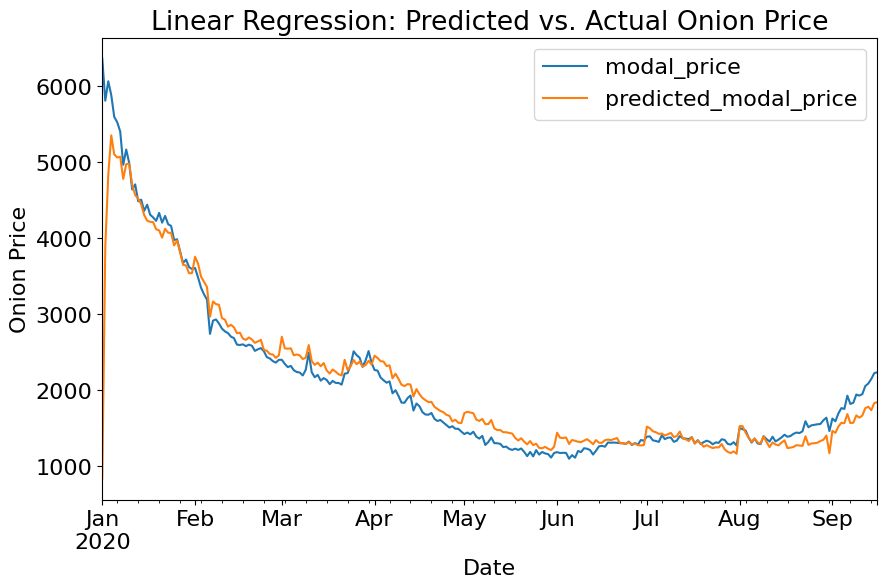

In [21]:
temp = df.copy() 
temp['preds'] = lin_reg.predict(temp[final_features])

plot_df = temp[['modal_price']].groupby(temp.index)[['modal_price']].mean()
plot_df['predicted_modal_price'] = temp[['preds']].groupby(temp.index)[['preds']].mean()
plot_df.plot()
plt.xlabel('Date')
plt.ylabel('Onion Price')
plt.title('Linear Regression: Predicted vs. Actual Onion Price')
plt.show()

## D)  MLP Regression Model
***
The MLP Neural Network yields lower RMSE and MAPE with higher R^2 values, indicating that this model fits the data better than the linear regression model and can yield stronger predictive power.

In [22]:
# Create linear regression object
regr = MLPRegressor(alpha=5e-5, hidden_layer_sizes=(50,), max_iter=2000)

# Train the model using the training sets
regr.fit(X_train, y_train);

In [23]:
# Make predictions using the testing set
y_pred = regr.predict(X_test)

print("===== MLP Model Performance =====")
# Root Mean Squared Error
print("RMSE: %.2f" % mean_squared_error(y_test, y_pred, squared=False))
# Mean Absolute Percentage Error
print("MAPE: %.2f" % mean_absolute_percentage_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("R^2: %.2f" % r2_score(y_test, y_pred))



===== MLP Model Performance =====
RMSE: 398.88
MAPE: 0.09
R^2: 0.93


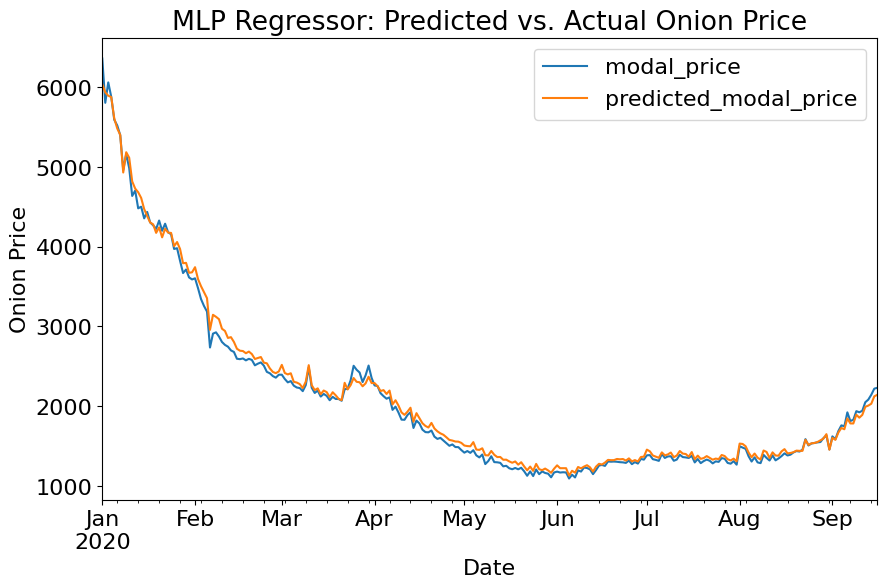

In [30]:
temp = df.copy() 
temp['preds'] = regr.predict(temp[final_features])

plot_df = temp[['modal_price']].groupby(temp.index)[['modal_price']].mean()
plot_df['predicted_modal_price'] = temp[['preds']].groupby(temp.index)[['preds']].mean()
plot_df.plot()
plt.xlabel('Date')
plt.ylabel('Onion Price')
plt.title('MLP Regressor: Predicted vs. Actual Onion Price')
plt.show()

# 5) Hyperparameter tuning (as needed)
***
Grid search across various hidden layer sizes and alpha(penalty term to combat overfitting) <br>
Score via RMSE <br>
Choose parameters that yield the highest RMSE <br>

In [31]:
def GridSearch(X_train, y_train):
    param_grid = {'hidden_layer_sizes': [(1,),(50,),(100,)], 
                  'alpha': [0.00005,0.0005]}

    clf = GridSearchCV(estimator=MLPRegressor(max_iter=2000), param_grid=param_grid, 
                       scoring='neg_root_mean_squared_error')
    clf.fit(X_train, y_train)
    
    print("Best MLPR Paramters: ")
    print(clf.best_params_)
    return clf.best_params_['hidden_layer_sizes'], clf.best_params_['alpha']

In [32]:
hl, alpha = GridSearch(X_train, y_train)

Best MLPR Paramters: 
{'alpha': 0.0005, 'hidden_layer_sizes': (100,)}


In [33]:
best_MLPR = MLPRegressor(hidden_layer_sizes=hl, alpha=alpha, max_iter=2000)

In [34]:
# Make predictions using the testing set
best_MLPR.fit(X_train, y_train)
y_pred = best_MLPR.predict(X_test)

print("===== Optimal Model Performance =====")
# Root Mean Squared Error
print("RMSE: %.2f" % mean_squared_error(y_test, y_pred, squared=False))
# Mean Absolute Percentage Error
print("MAPE: %.2f" % mean_absolute_percentage_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("R^2: %.2f" % r2_score(y_test, y_pred))

===== Optimal Model Performance =====
RMSE: 396.87
MAPE: 0.08
R^2: 0.93


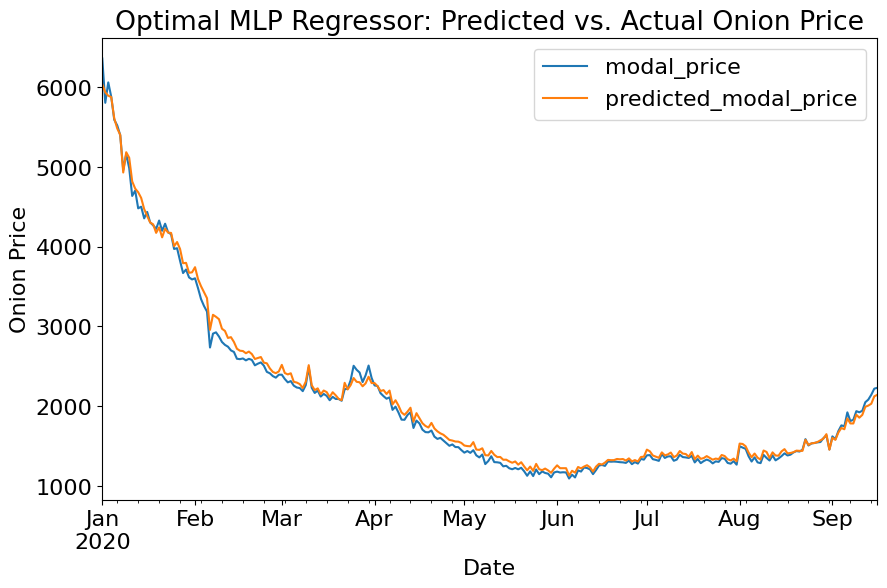

In [35]:
temp = df.copy() 
temp['preds'] = regr.predict(temp[final_features])

plot_df = temp[['modal_price']].groupby(temp.index)[['modal_price']].mean()
plot_df['predicted_modal_price'] = temp[['preds']].groupby(temp.index)[['preds']].mean()
plot_df.plot()
plt.xlabel('Date')
plt.ylabel('Onion Price')
plt.title('Optimal MLP Regressor: Predicted vs. Actual Onion Price')
plt.show()

## Considerations

- Modeling based historical data in an environment with rapidly changing external conditions (an export ban) may lead to results that are considerably different than actual results after the export ban takes effect.
- Volatility will likely continue to change considerably after the export ban takes effect

## Next Steps


Productionization:
- How will this model be used? Will time to predict be important? Explore fit & predict times in more detail
- What will ongoing monitoring look like?

Explore Additional Feature Engineering:
- Explore Forward - there may be diminishing returns of adding similar features such as multiple 30 day MA metrics, and this would potentially allow us to trim down feature space
- Adding in additional datasets. Seasonal onion demand
- Adding in unsurpervised learners to add further structure (ie cluster modal_price by region/onion)
- Tuning additional hyperparameters
- Testing additional regression models such as Ridge or LASSO

Explore splines and seasonality
- Model predictions diverge from actuals in September as variance increases. Explore additional methods of combatting this.